In this document, we run a set of experiments, based off Lechao's suggestion, for high-dimensional loss dynamics of a streaming SGD least squares linear regression problem. 

In this setup, we suppose that there is a hidden dimension $V$.  Data arrives in distribution $\mathscr{D}$, which is normally distributed, with diagonal, powerlaw covariance. So if $X \sim \mathscr{D}$ then we have $X_j \sim N(0, j^{-\alpha})$ and these are independent over $j$.  

These are labelled by some $\langle X, \hat \beta\rangle + \eta \epsilon$, where $\hat \beta$ is a $V$-dimensional vector, $\epsilon$ is normally distributed noise and $\eta > 0$ is a noise parameter.  The vector $\hat \beta$ is also power law, with $\hat \beta_j = j^{-\beta}.$  _We shall take $\eta=0$.  For producing scaling laws, it should scale with $D$._

Now $X$ is not released to optimizer.  Instead, the optimizer accesses $W^T X$ where $W$ is a $(D \times V)$--dimensional matrix.  This is by design, and the question is how should $D$ be picked to minimize the loss, _for a given total compute budget_
In particular, the dimension $D$ should be tunable.  The batchsize $B$ should be tunable.

Now we distinguish some cases:
* $2\alpha > 1$ (Fully localized).  In this case, we can take $V \to \infty$ and have a well-posed problem at finite $D$.  We can also take $V$ finite provided it is sufficiently large.  For example $V \geq D$ suffices, but in fact $V$ could even be somewhat smaller (although we don't pursue this).

* $2\alpha < 1 < 2(\alpha + \beta)$ (Localized target, delocalized input). In this case, there is in a sense lots of signal (and so as $V$ grows, the actual amount of information in the data grows with $V$.  The target, on the other hand, has bounded information content as $V$ grows.  It shall transpire that if $(D/V)V^{2\alpha} \to \infty$, then this regime has power law behavior.  When conversely $(D/V)V^{2\alpha} \to 0$, the problem trivializes in that only a vanishing fraction of the target can be fit using the model, and hence the problem setup degenerates.

* $2(\alpha + \beta) < 1$ (Fully delocalized).  Both input vector and output vector have growing information with $V$.  If $V \gg D$ then only a vanishing fractions of the target $\hat \beta$ can be recovered, and the problem trivializes.

Within these classes, we further distinguish the following:

* $\beta \geq \alpha$ ('simple target') In this case, the target in some sense contains less information than the input data.  In this regime, SGD convergence and scaling laws will be affected by SGD noise.  (When $\beta=\alpha$, it is a mild effect and will not change scaling exponents).

* $\beta < \alpha $ ('complicated target')  In this case, the target function is more complex than the input data, and hence SGD noise will only adjust the loss convergence by a multiplicative constant

*  $2\beta > 1$ ('bounded complexity target')  The target function has dimension-independent complexity.  Hence the model-misspecification (which measures how much of the target we are unable to fit) is dependent only on $\alpha$.  In this regime, the absolutely continuous spectra become important, as the principal directions in the loss (the first coordinate directions) are embedded into a power spectrum of eigenvalues of the random feature kernel ('The AC part').

*  $2\beta < 1$ ('high-dimensional target') In this case, the target complexity grows with $V$ (or is infinite, with $V =\infty$).  The model-misspecification depends on $\beta$.  

# General routines
General routines for running SGD, genning spectral densities, etc.

In [25]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import time
import functools
#from jax import config
#config.update("jax_enable_x64", True)

seed = 1
key = jax.random.PRNGKey(seed)
#jax.devices()

In [26]:
def jax_lsq_sgd(key,
                lr, batch, steps, init,
                t_oracle, loss, loss_times = jnp.array([0])
                ):
  """ This routine generates losses for SGD on the least squares
  problem with scalar targets, constant learning rate and constant batch size.

  Parameters
  ----------
  key : PRNGKey
    Jax PRNGKey
  lr : float
    The learning rate to use
  batch : int
    The batch-size to use
  steps : int
    The number of steps of minibatch SGD to generate
  init : vector
    The initial state for SGD to use
  t_oracle: callable
    Takes as an argument a jax RNG key and a batch-size.
    Expects in return two tensors (A, y)
    of dimension (batch x data-dimension) and dimension (batch).
  loss: callable
    Takes as an argument a vector of length data-dimension,
    which is the current linear model parameters, and returns the
    loss.
  loss_times: vector
    Iteration counts at which to compute the loss

  Returns
  -------
  losses: vector
    An array of length 'steps' containing the losses
  loss_times: vector
    Iteration counts at which the losses were computed
  """

  if loss_times.shape[0]==1:
    loss_times = jnp.arange(steps)
  x = jnp.reshape(init,(len(init),1))


  def update(x, keyz):
    A,y = t_oracle(keyz, batch)
    newx = x - lr*jnp.tensordot(A,jnp.tensordot(A,x,axes=1)-y,axes=[[0],[0]])
    return newx, newx

  keys=jax.random.split(key,steps)
 # update_jit = jax.jit(update)
  _, states = jax.lax.scan(update,x,keys)

  return jax.lax.map(loss, states[loss_times[loss_times< steps]]), loss_times[loss_times< steps]



In [27]:
def jax_lsq_sgd_opt(key,
                lr, batch, steps, init,
                t_oracle, loss
                ):
  """ This routine generates losses for SGD on the least squares
  problem with scalar targets, constant learning rate and constant batch size.
  It selects times (along a dense power law) at which to output the SGD losses and outputs those times.

  Parameters
  ----------
  key : PRNGKey
    Jax PRNGKey
  lr : float
    The learning rate to use
  batch : int
    The batch-size to use
  steps : int
    The number of steps of minibatch SGD to generate
  init : vector
    The initial state for SGD to use
  t_oracle: callable
    Takes as an argument a jax RNG key and a batch-size.
    Expects in return two tensors (A, y)
    of dimension (batch x data-dimension) and dimension (batch).
  loss: callable
    Takes as an argument a vector of length data-dimension,
    which is the current linear model parameters, and returns the
    loss.
  loss_times: vector
    Iteration counts at which to compute the loss

  Returns
  -------
  losses: vector
    An array of length 'steps' containing the losses
  loss_times: vector
    Iteration counts at which the losses were computed
  """

  if steps < 10**2:
    return jax_lsq_sgd(key,
                lr, batch, steps, init,
                t_oracle, loss)
  x = jnp.reshape(init,(len(init),1))

  def update(x, keyz):
    A,y = t_oracle(keyz, batch)
    newx = x - lr*jnp.tensordot(A,jnp.tensordot(A,x,axes=1)-y,axes=[[0],[0]])
    return newx, newx

  def skinny_update(x, keyz):
    A,y = t_oracle(keyz, batch)
    newx = x - lr*jnp.tensordot(A,jnp.tensordot(A,x,axes=1)-y,axes=[[0],[0]])
    return newx, False
  
  p = np.int32(np.ceil(np.log10(steps+1))+1)

  mkey1,mkey2= jax.random.split(key)
  keys=jax.random.split(mkey1,10**2)

  x, states = jax.lax.scan(update,x,keys)
  losslist = jax.lax.map(loss,states)
  timelist = jnp.arange(1,10**2+1,1)
  lastiter = 10**2

  mkeyout =  jax.random.split(mkey2,p-2)
  for j, mkey in enumerate(mkeyout,start=2):
    u=j-2
    def outerloop(x, keyz):
      mkeys = jax.random.split(keyz, 10**u)
      newx, _ = jax.lax.scan(skinny_update,x,mkeys)
      return newx, loss(newx)
    outerloopsteps = min( (steps-lastiter)//(10**u), 100)
    if outerloopsteps <= 0:
      break
    keys=jax.random.split(mkey,outerloopsteps)
    x, late_loss = jax.lax.scan(outerloop,x,keys)
    losslist=jnp.concatenate([losslist,late_loss])
    timelist =jnp.concatenate([timelist,lastiter + (10**u)*jnp.arange(1,outerloopsteps+1,1)])
    lastiter += 10**j
  return losslist, timelist


In [28]:
def tt_dbetacirc_limit(alpha, beta):
    """Generate coefficient that multiplies the power law on the norm of $D^{1/2}\circ{\beta}$
    assuming V/D is sufficiently large.  Excludes critical case $\beta=0.5$.

    Parameters
    ----------
    alpha,beta : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    TMAX = 1000.0
    c, _ = sp.integrate.quad(lambda x: 1.0/(1.0+x**(2*alpha)),0.0,TMAX)
    kappa=c**(-2.0*alpha)

    cstar=0

    if 2*beta >= 1:
        cstar = jnp.sum( jnp.arange(1,10000,1.0)**(-2.0*beta))/kappa
    
    if 2*beta < 1:
        cstar, _ = sp.integrate.quad(lambda x: (x**(-2.0*beta))/(kappa+x**(2*alpha)),0.0,TMAX)

    return cstar


In [29]:
def tt_kappa_VD(alpha, V,D):
    """Generate coefficient kappa with finite sample corrections.

    
    Parameters
    ----------
    alpha : float
        parameter of the model.
    V,D : integers
        parameters of the model.

    Returns
    -------
    theoretical prediction for kappa parameter
    """

    TMAX = 1000.0
    c, _ = sp.integrate.quad(lambda x: 1.0/(1.0+x**(2*alpha)),0.0,TMAX)
    kappa=c**(-2.0*alpha)

    kappa_it = lambda k : sp.integrate.quad(lambda x: 1.0/(k+x**(2*alpha)),0.0,V/D)[0]
    eps = 10E-4
    error = 1.0
    while error > eps:
        kappa1 = 1.0/kappa_it(kappa)
        error = abs(kappa1/kappa - 1.0)
        kappa = kappa1
    return kappa

In [30]:
def tt_tau_VD(alpha, V,D):
    """Generate coefficient tau with finite sample corrections.

    
    Parameters
    ----------
    alpha : float
        parameter of the model.
    V,D : integers
        parameters of the model.

    Returns
    -------
    theoretical prediction for kappa parameter
    """

    tau_it = lambda k : jnp.sum( 1.0/(D*(jnp.arange(1,V,1)**(2*alpha) +k)))
    tau = tau_it(0)
    eps = 10E-4
    error = 1.0
    while error > eps:
        tau1 = 1.0/tau_it(tau)
        error = abs(tau1/tau - 1.0)
        tau = tau1
    return tau

In [31]:
def tt_dbetacirc_VD(alpha, beta,V,D):
    """Generate the 'exact' finite V, D expression for $D^{1/2}\circ{\beta}$.

    Parameters
    ----------
    alpha,beta : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    cstar = 0.0
    if 2*alpha >= 1.0:
        kappa = tt_kappa_VD(alpha,V,D)
        cstar = jnp.sum( jnp.arange(1,V,1.0)**(-2.0*(beta+alpha))/( jnp.arange(1,V,1.0)**(-2.0*(alpha))*kappa*(D**(2*alpha)) + 1.0))

    if 2*alpha < 1.0:
        #tau = D/jnp.sum( jnp.arange(1,V,1.0)**(-2.0*alpha))
        tau = tt_tau_VD(alpha,V,D)
        cstar = jnp.sum( jnp.arange(1,V,1.0)**(-2.0*(beta+alpha))/( jnp.arange(1,V,1.0)**(-2.0*(alpha))*tau + 1.0))

    
    return cstar


In [32]:
def tt_knorm_limit(alpha, beta, V, D, gamma,B=1):
    """Generate the kernel norm of the Volterra equation

    
    Parameters
    ----------
    alpha,beta,V,D, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    f = lambda x : x**(-2.0*alpha)/(1.0-gamma*x**(-2.0*alpha))
    return jnp.sum( f(jnp.arange(1,V,1.0)))*gamma/2.0


In [33]:
def tt_pp_coefficient(alpha, beta, V, D, gamma,B=1):
    """Generate the coefficient that appears before the asymptotic 
    "for the gradient flow in the pure point part of the spectrum

    
    Parameters
    ----------
    alpha,beta,V,D, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """

    return sp.special.gamma( (beta-0.5)/alpha + 1.0) * (2*gamma*B)**( -1.0*(beta-0.5)/alpha - 1.0) / (2*alpha)

In [34]:
def tt_Kpp_coefficient(alpha, beta, V, D, gamma,B=1):
    """Generate the coefficient that appears before the asymptotic 
    "for the kernel term in the pure point part of the spectrum

    
    Parameters
    ----------
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """

    return sp.special.gamma( -0.5/alpha + 2.0) * (2*gamma*B)**( 0.5/alpha - 2.0) / (2*alpha)

In [35]:
def tt_Fac_coefficient(alpha, beta, V, D, gamma,B=1):
    """Generate the coefficient that appears before the asymptotic 
    "for the gradient flow in the pure point part of the spectrum

    
    Parameters
    ----------
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """

    f = lambda x : x**(-2.0*beta)
    return sp.special.gamma( -0.5/alpha + 1.0) * jnp.sum(f(jnp.arange(1,V,1)))* (2*gamma*B)**( 0.5/alpha - 1.0) / (2*alpha)

In [36]:
def tt_sgd_coefficient(alpha, beta, V, D, gamma,B=1):
    """Generate the coefficient that appears before the asymptotic 
    "for the SGD noise term

    
    Parameters
    ----------
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """

    return sp.special.gamma( (-0.5)/alpha + 2.0) * (2*gamma*B)**( 1.0*(0.5)/alpha - 2.0) / (2*alpha)

In [37]:
def tt_Fnorm_limit(alpha, beta, V, D, gamma,B=1):
    """Generate the kernel norm of the Volterra equation

    
    Parameters
    ----------
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    f = lambda x : x**(-2.0*beta)/(1.0-gamma*x**(-2.0*alpha))
    return jnp.sum( f(jnp.arange(1,V,1.0)))*(1.0/(2.0*gamma*B))


In [38]:
def tt_lmin(alpha):
    """Generate left edge of the spectral measure

    
    Parameters
    ----------
    alpha : float
        parameter of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    TMAX = 1000.0
    c, _ = sp.integrate.quad(lambda x: 1.0/(1.0+x**(2*alpha)),0.0,TMAX)

    return (1/(2*alpha-1))*((2*alpha/(2*alpha-1)/c)**(-2*alpha))


In [39]:
def tt_p(alpha):
    """Generate the coefficient that appears in the semicircular approximation at the left edge.
    

    Parameters
    ----------
    alpha : float
        parameter of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the norm
    """

    TMAX = 1000.0
    c, _ = sp.integrate.quad(lambda x: 1.0/(1.0+x**(2*alpha)),0.0,TMAX)

    return ((alpha-0.5)/c)*((2*alpha/(2*alpha-1)/c)**(-2*alpha-1))


In [40]:
def tt_sce_coefficient(alpha, beta, gamma,B=1):
    """Generate the coefficient that appears before the asymptotic 
    "for the gradient flow term coming from the semicircular edge

    
    Parameters
    ----------
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """
    f = lambda x : x**(-2.0*beta)
    return (1.0/jnp.pi) * (
        sp.special.gamma( 1.5) 
        * jnp.sum( f(jnp.arange(1,10000,1.0))) 
        * (1.0/(jnp.sqrt(tt_p(alpha))*(2*alpha-1)**2))
        * (1.0/(2*gamma*B))**(1.5)
        )

In [41]:
def tt_pp_pretty(times, alpha, beta, V, D, gamma,B=1):
    """Generate the pretty version of the pure point
    forcing function.  This just uses eigenvalues j^{-2alpha}.

    
    Parameters
    ----------
    times : vector
        times at which to evaluate the prediction
    alpha,beta,V,D,gamma : floats
        parameters of the model, ASSUMES V>D

    B = 1 : int
        batch parameter
    Returns
    -------
    theoretical prediction for the coefficient
    """
    Dbeta = jnp.arange(1,V,1)**(-2*(alpha+beta))
    pp = jnp.arange(1,V,1)**(-2*alpha)
    preexp = 1.0 - (2*gamma*B)*pp + (2*gamma**2*B)*(pp*pp)
    diffs = jnp.diff(times,prepend=jnp.array([0]))

    def pp_loss(krn,r): 
        krn = krn*(preexp**r)
        return krn, jnp.sum(Dbeta*krn)
    _,out = jax.lax.scan(pp_loss,jnp.ones_like(preexp),diffs)
    return out


In [42]:
def tt_Kpp_pretty(times, alpha, beta, V, D, gamma,B=1):
    """Generate the pretty version of the pure point
    kernel function.  This just uses eigenvalues j^{-2alpha}.
    
    Parameters
    ----------
    times : vector
        times at which to evaluate the prediction
    alpha,beta,V,D,gamma : floats
        parameters of the model, ASSUMES V>D

    B = 1 : int
        batch parameter
    Returns
    -------
    theoretical prediction for the coefficient
    """
    Dbeta = jnp.arange(1,V,1)**(-4*alpha)
    pp = jnp.arange(1,V,1)**(-2*alpha)
    preexp = 1.0 - (2*gamma*B)*pp + (2*gamma**2*B)*(pp*pp)
    diffs = jnp.diff(times,prepend=jnp.array([0]))
    def pp_loss(krn,r): 
        krn = krn*(preexp**r)
        return krn, jnp.sum(Dbeta*(krn))
    _,out = jax.lax.scan(pp_loss,jnp.ones_like(preexp),diffs)
    return out


In [43]:
def tt_Fac_pretty(times, alpha, beta, V, D, gamma,B=1):
    """Generate the pretty version of the AC spectrum loss

    
    Parameters
    ----------
    times : vector
        times at which to evaluate the prediction
    alpha,beta, gamma : floats
        parameters of the model, ASSUMES V>D

    Returns
    -------
    theoretical prediction for the coefficient
    """

    f = lambda x : x**(-2.0*beta)
    return sp.special.gamma( -0.5/alpha + 1.0) * jnp.sum(f(jnp.arange(1,V,1)))* (2*gamma*B*times)**( 0.5/alpha - 1.0) / (2*alpha*D)

In [44]:
def tt_pareto(times, c0,g0,p0,c1,g1,p1):
    """Generate the pareto frontier.
     This is done by optimizing 
     
     c0 (F/d)^{-g0} d^{-p0} + c1 (F/d)^{-g1} d^{-p1} 

     with F in flops.  The (c0,g0,p0) curve hould be above (c1,g1,p1)
    for earlier times

    
    Parameters
    ----------
    times : vector
        times at which to evaluate the prediction
    cj,gj,pj : floats
        coefficients in the power law that appear

    Returns
    -------
    pareto curve at the times 
    """

    if p1 < g1:
        raise Exception("p1 must be larger than g1 but got {} < {}".format(p1,g1))
    if g0 < p0:
        raise Exception("g0 must be larger than p0 but got {} < {}".format(g0,p0))
    
#    ds = (((c1/c0)*(p1-g1)/(g0-p0))*times**(g0-g1))**(1.0/(g0-p0-g1+p1))
    ds = (((c1/c0)*(p1-g1)/(g0-p0))**(1.0/(g0-p0-g1+p1)))*times**((g0-g1)/(g0-p0-g1+p1))


    return c0*(times**(-g0))*(ds**(g0-p0)) + c1*(times**(-g1))*(ds**(g1-p1))
    

In [63]:
def tt_pareto_corner(times, c0,g0,p0,c1,g1,p1):
    """Generate the pareto frontier with a max-ansatz.
     This is done by optimizing 
     
     max(c0 (F/d)^{-g0} d^{-p0}, c1 (F/d)^{-g1} d^{-p1})

     with F in flops.  The (c0,g0,p0) curve hould be above (c1,g1,p1)
    for earlier times

    
    Parameters
    ----------
    times : vector
        times at which to evaluate the prediction
    cj,gj,pj : floats
        coefficients in the power law that appear

    Returns
    -------
    pareto curve at the times 
    """

    if (g1 - g0)/(g1 - p1 -g0 + p0) < 0:
        raise Exception("must have (g1 - g0)/(g1 - p1 -g0 + p0) > 0")
    
    c0 = np.float128(c0)
    g0 = np.float128(g0)
    p0 = np.float128(p0)

    c1 = np.float128(c1)
    g1 = np.float128(g1)
    p1 = np.float128(p1)

    nptimes = np.array(times,dtype=np.float128)
#    ds = (((c1/c0)*(p1-g1)/(g0-p0))*times**(g0-g1))**(1.0/(g0-p0-g1+p1))
    ds = (((c0/c1))**(1.0/(g1-p1-g0+p0)))*nptimes**((g1-g0)/(g1-p1-g0+p0))


    return c0*(nptimes**(-g0))*(ds**(g0-p0))
    

In [64]:
x = jnp.ones(10)
np.array(x,dtype=np.float128)
tt_pareto_corner(x,jnp.float16(1.0),0.0,0.0,1.0,2.0,1.0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float128)

# Run all phases


In [45]:
#number of times to run SGD per D
RUNS = 5
#NUMBER OF FLOPS
flop_steps = 10**9

#noise 0
eta = 0.0
#this will multiply the data-norm (sum on j of j^{-2alpha} from 1 to V) 
gamma_mult=0.75
#batch size
Batch=1

#VLIST=[20000,20000,20000,20000,20000,20000]
DLIST=[100,200,400,800,1600,3200]
#DLIST=[100,200,400]

PHASES = [(0.75,0.25), (1.25,0.75), (1.0,2.0), (0.25,2.0), (0.33,0.45), (0.45,0.33)]


In [46]:
loss_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
loss_list_opt = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
times_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
v_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)
gamma_list = dict((phase,dict((key, []) for key in DLIST)) for phase in PHASES)

#set all Vs to be used to be D*10
for p in PHASES:
  for D in DLIST:
    v_list[p][D]=D*10


In [ ]:
PHASES_TO_RUN = PHASES

#PHASES_TO_RUN = [(0.15,0.33)]

for p in PHASES_TO_RUN:
  loss_list[p] = dict((key, []) for key in DLIST)
  loss_list_opt[p] = dict((key, []) for key in DLIST)
  times_list[p] = dict((key, []) for key in DLIST)

for (alpha,beta) in PHASES_TO_RUN:
  p=(alpha,beta)
  for D in DLIST:
    start=time.time()
    V=v_list[p][D]
    steps = flop_steps//D
    omega = 1.0/jnp.float32(D)

    gamma = gamma_mult/jnp.sum(jnp.arange(1,V,1)**(-2.0*alpha))

    gamma_list[p][D] = gamma

    data_scale = jnp.power(jnp.arange(1,V+1,dtype=jnp.float32),-1.0*alpha)
    check_beta = jnp.power(jnp.arange(1,V+1,dtype=jnp.float32),-1.0*(beta+alpha))
    check_beta = jnp.reshape(check_beta,(V,1))

    for j in range(RUNS):  
      key,nkey = jax.random.split(key)
      W = jnp.sqrt(omega)*jax.random.normal(nkey, (V,D))

      #move power-scaling from X's to beta and W to save computation
      check_W = jnp.reshape(data_scale,(V,1)) * W
      def ab_oracle(key,batch):
        key,nkey = jax.random.split(key)
        xs = jax.random.normal(nkey,(batch, V))
        A = jnp.tensordot(xs,check_W,1)
        key,nkey = jax.random.split(key)
        noise = jax.random.normal(nkey,(batch,1))
        y = jnp.tensordot(xs,check_beta,1) + eta*noise
        return A,y

      def square_loss(theta):
        v=jnp.tensordot(check_W,theta,1) - check_beta
        return jnp.sum(v*v)

      #ab_oracle_jit = functools.partial(jax.jit,static_argnums=1)(ab_oracle)
      #square_loss_jit = functools.partial(jax.jit)(jax.jit(square_loss))
      #ab_oracle_jit = jax.jit(ab_oracle)
      #square_loss_jit = jax.jit(square_loss)

      key,nkey = jax.random.split(key)
      losses,times = jax_lsq_sgd_opt(nkey,gamma,Batch,steps,jnp.zeros(D),
                                ab_oracle,square_loss)

      loss_list[p][D].append(losses)
      times_list[p][D].append(times)
    end=time.time()
    print("Completed (D,a,b)=({},{},{}) in time: {}s".format(D,alpha,beta,end-start))
  


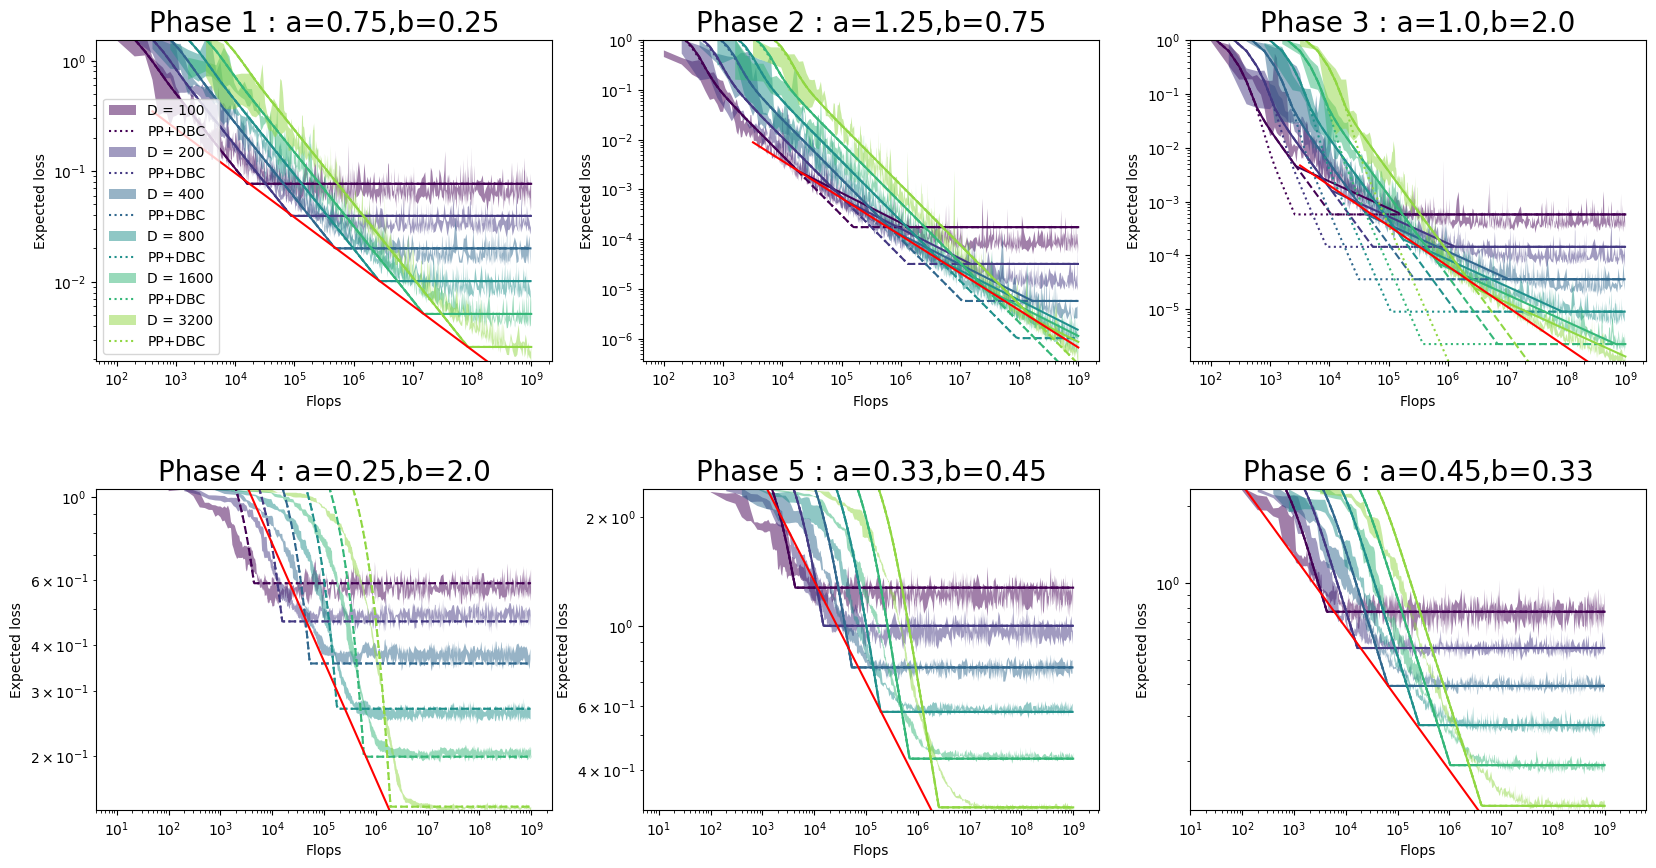

In [103]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.subplots_adjust(hspace=0.4)
axs = np.reshape(axs,(6,))
cs= plt.colormaps.get_cmap("viridis")

for p, (alpha,beta) in enumerate(PHASES):

  loss_lower_decile = dict((key, []) for key in DLIST)
  loss_upper_decile = dict((key, []) for key in DLIST)
  times_single_list = dict((key, []) for key in DLIST)



  gamma1 = 0.0
  if 2*beta >= 1.0:
    gamma1 = 2*alpha
  if 2*beta < 1.0:
    gamma1 = 2*(alpha + beta)-1.0

  gamma0 = 1.0*(1+beta/alpha)-0.5/alpha

  gamma2 = 1.0 - 0.5/alpha

  gamma3 = 2.0 - 0.5/alpha

  gamma4 = 1.5

  ylim_lower = 1.0
  ylim_upper = 1.0


  for i,D in enumerate(DLIST):
    loss_lower_decile[D] = jnp.quantile(jnp.array(loss_list[(alpha,beta)][D]),0.25,axis=0)
    loss_upper_decile[D] = jnp.quantile(jnp.array(loss_list[(alpha,beta)][D]),0.75,axis=0)
    times_single_list[D]= times_list[(alpha,beta)][D][0]
    axs[p].fill_between(times_single_list[D]*D*Batch,
                    loss_lower_decile[D],
                    loss_upper_decile[D],
                    label="D = {}".format(D), facecolor=cs(i/len(DLIST), alpha=0.5)
                    )

    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    knorm = (tt_knorm_limit(alpha,beta,V,D,gamma))
    dbetacirc = tt_dbetacirc_VD(alpha,beta,V,D)#*(D**(gamma1))
    pp_pretty = tt_pp_pretty(times_single_list[D],alpha,beta,V,D,gamma,Batch)

    Kpp_pretty = tt_Kpp_pretty(times_single_list[D],alpha,beta,V,D,gamma,Batch)

    f0_pretty = dbetacirc*jnp.ones_like(times_single_list[D])

    Fnorm = tt_Fnorm_limit(alpha, beta, V, D, gamma)
    pp_cumsum = jnp.cumsum(pp_pretty)

    Kterm_pretty = (gamma**2*Batch/(1.0-knorm))*Kpp_pretty*pp_cumsum

    AC = tt_Fac_pretty(times_single_list[D],alpha,beta,V,D,gamma,Batch)
    if 2*beta < 1:
      AC = AC*0

    pp_dbc = jnp.maximum(f0_pretty,pp_pretty)*(1.0/(1.0-knorm))
    axs[p].plot(times_single_list[D]*D, pp_dbc, label="PP+DBC",c=cs(i/len(DLIST)), linestyle='dotted')
    pp_dbc_k = jnp.maximum(pp_dbc,Kterm_pretty*(1.0/(1.0-knorm)))
    axs[p].plot(times_single_list[D]*D, pp_dbc_k, c=cs(i/len(DLIST)), linestyle='dashed')
    pp_dbc_k_ac = jnp.maximum(pp_dbc_k,AC*(1.0/(1.0-knorm)))
    axs[p].plot(times_single_list[D]*D, pp_dbc_k_ac, c=cs(i/len(DLIST)))


    
    ylim_lower = min(ylim_lower, loss_lower_decile[D][-1])
    ylim_upper = max(ylim_upper, loss_lower_decile[D][0])

  if p == 0:
    D = 400
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = times_list[(alpha,beta)][D][0]*D
    g1 = 0.0
    p1 = 2*alpha+2*beta-1
    c1 = tt_dbetacirc_VD(alpha,beta,V,D)*(D**(p1))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    g0 = 1.0*(1+beta/alpha)-0.5/alpha
    p0 = 0.0
    c0 = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    axs[p].plot(opts_ts,tt_pareto_corner(opts_ts,c0,g0,p0,c1,g1,p1), c='red')


  #the tradeoff in this case is between the AC term and the limiting level
  #However this optimization problem is degenerate (it always pays to increase d),
  #There is however a constraint, which is that we cannot increase d past the point that
  #the AC term overtakes the PP term.  So this constrains the problem, and we give below the constrained solution
  if p == 1:
    D = DLIST[-1]
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = times_list[(alpha,beta)][D][0]*D
    #g1 = 0.0
    #p1 = 2*alpha
    #c1 = tt_dbetacirc_VD(alpha,beta,V,D)*(D**(p1))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    g_ac = 1.0-0.5/alpha
    p_ac = 1.0
    c_ac = tt_Fac_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    g_pp = 1.0*(1+beta/alpha)-0.5/alpha
    p_pp = 0.0
    c_pp = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    ds = (c_ac/c_pp)**(alpha/(alpha+beta))*(opts_ts)**(beta/(alpha+beta))
    constrained_opt = c_pp * (opts_ts)**(-g_pp) * (ds**(g_pp))

    axs[p].plot(opts_ts,constrained_opt, c='red')
    #axs[p].plot(opts_ts,tt_pareto(opts_ts,c0,g0,p0,c1,g1,p1), c='red')        

  # #For comparison, we also show the compute optimal curve where we ignore the AC spectrum and just optimize 
  # #the F_PP + F_0 curve
  # if p == 1:
  #   D = DLIST[-1]
  #   V=v_list[(alpha,beta)][D]
  #   gamma=gamma_list[(alpha,beta)][D]
  #   opts_ts = times_list[(alpha,beta)][D][0]*D
  #   g1 = 0.0
  #   p1 = 2*alpha
  #   c1 = tt_dbetacirc_VD(alpha,beta,V,D)*(D**(p1))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
  #   #g0 = 1.0-0.5/alpha
  #   #p0 = 1.0
  #   #c0 = tt_Fac_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
  #   g0 = 1.0*(1+beta/alpha)-0.5/alpha
  #   p0 = 0.0
  #   c0 = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
  #   #axs[p].plot(opts_ts,tt_pareto(opts_ts,c0,g0,p0,c1,g1,p1), c='grey')    

#The tradeoff is given in terms of the SGD term and the AC term
  if p == 2:
    D = DLIST[-1]
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = times_list[(alpha,beta)][D][0]*D
    g1 = 1.0-0.5/alpha
    p1 = 1.0
    c1 = tt_Fac_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    g0 = 2.0-0.5/alpha
    p0 = 0.0
    c0 = tt_Kpp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))
    axs[p].plot(opts_ts,tt_pareto_corner(opts_ts,c0,g0,p0,c1,g1,p1), c='red')  


#The tradeoff is given in terms of the PP term and the F0 term
  if p == 3:
    D = 3200
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = jnp.logspace(1,jnp.log10(flop_steps),100)
    TAU = D/(jnp.sum(jnp.arange(1,V,1)**(-2*alpha)))
    #TAU = tt_tau_VD(alpha,V,D)
    g_0 = 0.0
    p_0 = 1.0
    c_0 = tt_dbetacirc_VD(alpha,beta,V,D)*(TAU**(p_0))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    #c_0 = tt_dbetacirc_VD(alpha,beta,V,D)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    #replace c_0 r^{-g_0} tau^{-p_0} by an expression only involving d
    c_0 = c_0 * ( ( ( (V/D)**(2*alpha-1) )/(1-2*alpha))**(-p_0) )
    p_0 = p_0*(2*alpha)
    
    g_pp = 1.0*(1.0+beta/alpha)-0.5/alpha
    p_pp = 0.0
    c_pp = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    c_pp = c_pp * ((V/D)**(2*alpha-1)/(1-2*alpha))**(g_pp)
    p_pp = p_pp - g_pp*(1-2*alpha)

    axs[p].plot(opts_ts, tt_pareto_corner(opts_ts,c_pp,g_pp,p_pp,c_0,g_0,p_0), c='red')

#The tradeoff involves the AC term, which is still unknown
  if p == 4:
    D = 3200
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = jnp.logspace(1,jnp.log10(flop_steps),100)
    TAU = D/(jnp.sum(jnp.arange(1,V,1)**(-2*alpha)))
    TAU = tt_tau_VD(alpha,V,D)    
    g_0 = 0.0
    p_0 = (2*alpha+2*beta-1)/(2*alpha)
    c_0 = tt_dbetacirc_VD(alpha,beta,V,D)*(TAU**(p_0))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    #replace c_0 r^{-g_0} tau^{-p_0} by an expression only involving d
    c_0 = c_0 * ((V/D)**(2*alpha-1)/(1-2*alpha))**(-p_0)
    p_0 = p_0*(2*alpha)

    g_pp = 1.0*(1+beta/alpha)-0.5/alpha
    p_pp = 0.0
    c_pp = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    c_pp = c_pp * ((V/D)**(2*alpha-1)/(1-2*alpha))**(g_pp)
    p_pp = p_pp - g_pp*(1-2*alpha)

    #taus = (c_ac/c_pp)**(alpha/(alpha+beta))*(opts_ts)**(beta/(alpha+beta))
    #constrained_opt = c_pp * (opts_ts)**(-g_pp) * (ds**(g_pp))
    axs[p].plot(opts_ts,tt_pareto_corner(opts_ts,c_pp,g_pp,p_pp,c_0,g_0,p_0), c='red')


#The tradeoff involves the AC term, which is still unknown
  if p == 5:
    D = 3200
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = jnp.logspace(1,jnp.log10(flop_steps),100)
    TAU = D/(jnp.sum(jnp.arange(1,V,1)**(-2*alpha)))
    TAU = tt_tau_VD(alpha,V,D)
    g_0 = 0.0
    p_0 = (2*alpha+2*beta-1)/(2*alpha)
    c_0 = tt_dbetacirc_VD(alpha,beta,V,D)*(TAU**(p_0))/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    #replace c_0 r^{-g_0} tau^{-p_0} by an expression only involving d
    c_0 = c_0 * ((V/D)**(2*alpha-1)/(1-2*alpha))**(-p_0)
    p_0 = p_0*(2*alpha)

    g_pp = 1.0*(1+beta/alpha)-0.5/alpha
    p_pp = 0.0
    c_pp = tt_pp_coefficient(alpha,beta,V,D,gamma)/(1.0 - tt_knorm_limit(alpha,beta,V,D,gamma))

    c_pp = c_pp * ((V/D)**(2*alpha-1)/(1-2*alpha))**(g_pp)
    p_pp = p_pp - g_pp*(1-2*alpha)

    #taus = (c_ac/c_pp)**(alpha/(alpha+beta))*(opts_ts)**(beta/(alpha+beta))
    #constrained_opt = c_pp * (opts_ts)**(-g_pp) * (ds**(g_pp))
    axs[p].plot(opts_ts,tt_pareto_corner(opts_ts,c_pp,g_pp,p_pp,c_0,g_0,p_0), c='red')

  axs[p].set_title('Phase {} : a={},b={}'.format(p+1,alpha,beta), fontsize = '20')

  axs[p].set_xlabel('Flops')
  axs[p].set_ylabel('Expected loss')

  axs[p].set_yscale('log')
  axs[p].set_xscale('log')

  axs[p].set_ylim([ylim_lower,ylim_upper])

axs[0].legend()
#plt.show()

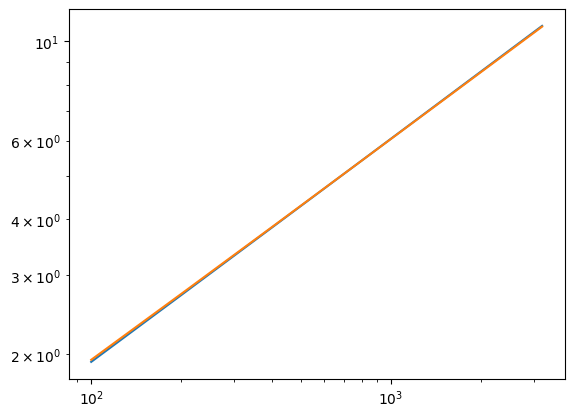

In [85]:
alpha = 0.25 
beta = 2.0
tau_true_list = []
tau_other_list = []


for D in DLIST:
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = jnp.logspace(1,jnp.log10(flop_steps),100)
    TAU = D/(jnp.sum(jnp.arange(1,V,1)**(-2*alpha)))
    tau_true_list.append(tt_tau_VD(alpha, V, D))
    tau_other_list.append(TAU)

plt.plot(DLIST, tau_true_list, label = 'true')
plt.plot(DLIST, 1.2*jnp.array(tau_other_list), label = 'other')

plt.yscale('log')
plt.xscale('log')

6.8039618
7.6833653
8.514711
9.308895
10.07517
10.820877


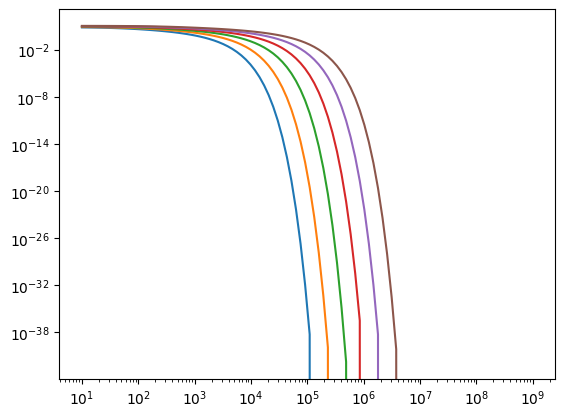

In [92]:
alpha = 0.25 
beta = 2.0



for D in DLIST:
    V=v_list[(alpha,beta)][D]
    gamma=gamma_list[(alpha,beta)][D]
    opts_ts = jnp.logspace(1,jnp.log10(flop_steps),100)
    something = tt_Kpp_pretty(opts_ts, alpha, beta, V, D, gamma)
    plt.plot(opts_ts, tt_Kpp_pretty(opts_ts, alpha, beta, V, D, gamma))
    print(something[1])
    #TAU = D/(jnp.sum(jnp.arange(1,V,1)**(-2*alpha)))
    #tau_true_list.append(tt_tau_VD(alpha, V, D))
    #tau_other_list.append(TAU)

#plt.plot(DLIST, tau_true_list, label = 'true')
#plt.plot(DLIST, 1.2*jnp.array(tau_other_list), label = 'other')

plt.yscale('log')
plt.xscale('log')